# COMP5318: Assignment Final Stage
By: Jesse Serina Narvasa (jnar3156)

## Notebook setup

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from collections import OrderedDict
from IPython.display import HTML
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Static Variables

INPUT_DATA_PATH = 'drive/My Drive/Colab Notebooks/data/input/'
OUTPUT_DATA_PATH = 'drive/My Drive/Colab Notebooks/data/output/'
FILENAMES = ['2019.xlsx', '2018.xlsx', '2017.xlsx', '2016.xlsx', '2015.xlsx', '2014.xlsx', '2013.xlsx', '2012.xls', '2011.xls', '2010.xls', '2009.xls', '2008.xls', '2007.xls', '2006.xls', '2005.xls', '2004.xls', '2003.xls', '2002.xls', '2001.xls']
OUTPUT_DATASET_FILE = 'output_clean.xlsx'

In [3]:
# Column headers
columns = pd.read_excel(INPUT_DATA_PATH + FILENAMES[0], header=None)
columns = columns.loc[0,:].values.tolist()

# instantiating an empty dataframe
df = pd.DataFrame(columns=columns)

# iterating through our files to load all the training data for different years
for filename in FILENAMES:
    data = pd.read_excel(INPUT_DATA_PATH + filename, index_col=None, header=0)
    df = df.append(data, ignore_index=True)

# loading our dataframe
df

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,WPts,LPts,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL,EXW,EXL,LBW,LBL,SJW,SJL,UBW,UBL,CBW,CBL,IWW,IWL,SBW,SBL,B&WW,B&WL,GBW,GBL
0,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Dimitrov G.,Nishioka Y.,19.0,75,1835.0,701.0,6.0,3.0,6,4,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.36,3.00,1.36,3.37,1.42,3.60,1.35,3.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Raonic M.,Bedene A.,18.0,67,1855.0,780.0,6.0,0.0,6,3,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.18,4.50,1.23,4.68,1.27,4.84,1.22,4.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Kecmanovic M.,Mayer L.,131.0,56,433.0,895.0,6.0,3.0,6,1,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,1.57,2.25,1.67,2.32,1.71,2.40,1.63,2.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Millman J.,Sandgren T.,38.0,61,1083.0,814.0,7.0,6.0,6,7,6,0,NaN,NaN,NaN,NaN,2.0,1.0,Completed,1.40,2.75,1.41,3.13,1.45,3.20,1.40,2.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Uchiyama Y.,Humbert U.,185.0,102,275.0,572.0,6.0,4.0,7,6,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,2.62,1.44,2.73,1.51,3.26,1.53,2.69,1.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51940,69,Sydney,Masters Cup,2001-11-12,Masters Cup,Indoor,Hard,Round Robin,3,Kafelnikov Y.,Ivanisevic G.,6.0,13,NaN,NaN,6.0,3.0,6,4,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.53,2.45,1.35,2.5,1.5,2.500,NaN,NaN,1.45,2.45
51941,69,Sydney,Masters Cup,2001-11-12,Masters Cup,Indoor,Hard,Round Robin,3,Kafelnikov Y.,Kuerten G.,6.0,1,NaN,NaN,6.0,2.0,4,6,6,3,NaN,NaN,NaN,NaN,2.0,1.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51942,69,Sydney,Masters Cup,2001-11-12,Masters Cup,Indoor,Hard,Semifinals,3,Grosjean S.,Kafelnikov Y.,7.0,6,NaN,NaN,6.0,4.0,6,2,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.05,1.70,1.80,1.7,2.1,1.667,NaN,NaN,1.95,1.70
51943,69,Sydney,Masters Cup,2001-11-12,Masters Cup,Indoor,Hard,Semifinals,3,Hewitt L.,Ferrero J.C.,2.0,4,NaN,NaN,6.0,4.0,6,3,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.45,2.55,1.20,3.3,1.3,3.200,NaN,NaN,1.20,3.80


## Data Pre-processing

In [4]:
def clean_data_1(df):
    '''
    Initial cleaning of our dataframe
    '''
    
    # Removing entries where the match was not completed
    df = df[df['Comment']=='Completed']
    
    # Remove Max and Avg Betting Odds columns
    df.drop(['MaxW', 'MaxL', 'AvgW', 'AvgL'], axis=1, inplace=True)
    
    # Creating a new feature consolidating the betting odds
    winner_odds_idx = list(range(28,df.shape[1],2))
    loser_odds_idx = list(range(29, df.shape[1],2))
    df['W_Avg_Odds'] = df.iloc[:, winner_odds_idx].mean(axis=1, skipna=True)
    df['L_Avg_Odds'] = df.iloc[:, loser_odds_idx].mean(axis=1, skipna=True)
    
    # Datatype conversion, changing inconsistent data values to NaN with errors='coerce'
    date_columns = ['Date']
    numeric_columns = ['WRank', 'LRank', 'WPts', 'LPts', 'W1', 'L1', 'W_Avg_Odds', 'L_Avg_Odds']
    df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    return df


def restructure_winner_loser(df):
    '''
    Purpose is to rearrange the dataframe, such that the features are not based on winner and loser,
    but structured based on Player and Opponent, where Player is always the person whom is losing the first set
    Output df is therefore with a new feature Has_Won, which indicates whether Player has won against Opponent
    '''
    
    # since our dataset is already structured, such that the winner and loser player is arranged for each event
    # then we need to create a new dataframe, such that the player behind will be relabelled as Player, and the other as 
    # Opponent respectively.  We can then provide labels on 0 or 1 for "has_won" which will be our new feature
    common_cols = ['Date', 'Court', 'Surface', 'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'WPts', 'LPts', 'W1', 'L1', 'W_Avg_Odds', 'L_Avg_Odds']
    winner_matches_df = df[common_cols].copy(deep=True)
    loser_matches_df = df[common_cols].copy(deep=True)

    winner_matches_df['Has_Won'] = 1
    loser_matches_df['Has_Won'] = 0
    
    winner_matches_df.rename(columns={
        'Winner': 'Player',
        'Loser': 'Opponent',
        'WRank': 'PRank',
        'LRank': 'ORank',
        'WPts': 'PPts',
        'LPts': 'OPts',
        'W1': 'P1',
        'L1': 'O1',
        'W_Avg_Odds': 'P_Avg_Odds',
        'L_Avg_Odds': 'O_Avg_Odds'
    }, inplace=True)

    loser_matches_df.rename(columns={
        'Loser': 'Player',
        'Winner': 'Opponent',
        'LRank': 'PRank',
        'WRank': 'ORank',
        'LPts': 'PPts',
        'WPts': 'OPts',
        'L1': 'P1',
        'W1': 'O1',
        'L_Avg_Odds': 'P_Avg_Odds',
        'W_Avg_Odds': 'O_Avg_Odds'
    }, inplace=True)

    # Now that we have the same columns for both winner and loser dataframes, we can now merge it back to training_df
    # except this time, each event is represented twice: first where the player is in col "Player" and then as "Opponent"
    # we will then later extract the rows where the player is behind effectively having a dataset where the player behind
    # is set as Player, with our classifier ("has_won") will then be mixed between 0 or 1, as opposed to our original dataset
    df = winner_matches_df.append(loser_matches_df)
    df['Set1_Diff'] = df['P1'] - df['O1']
    df.drop(['P1', 'O1'], axis=1, inplace=True)

    # We only want the rows where the player is behind. We therefore have restored our dataset back to the original row size
    df = df[df['Set1_Diff']<0]
    
    # Further reduction of features by condensing it
    df['Rank_Diff'] = df['PRank'] - df['ORank']
    df.drop(['PRank', 'ORank'], axis=1, inplace=True)
    
    df['Pts_Diff'] = df['PPts'] - df['OPts']
    df.drop(['PPts', 'OPts'], axis=1, inplace=True)

    # Sort the dataframe by date ASC
    df.sort_values(by=['Date', 'Round', 'Player'], inplace=True)

    # Reset the index
    df.reset_index(inplace=True, drop=True)
    
    return df


def create_momentum_feature(df):
    '''
    Creates the additional feature for Momentum.  This gives an insight to the player's recent form
    and adds an extra dimension for our classification model
    '''
    
    # Creating additional feature to show the momentum of the player coming into the game
    # This will take into account the past 10 matches of the player and opponent before the current row(event)
    df['PMomentum10'] = ''
    df['OMomentum10'] = ''

    for row in range(0,df.shape[0]):
        current_player = df['Player'][row]
        current_opponent = df['Opponent'][row]

        # Gets the last 10 matches of the player
        # Note that you purposely don't want the current match to be included.  This is why we only do slice(row-1),
        # and not slice(row), because we want the previous 10 matches - excluding the current one.
        dataset = df.loc[slice(row-1),:][(df['Player'] == current_player) | (df['Opponent'] == current_player)].tail(10)
        momentum = ((dataset['Player']==current_player).astype(int)*dataset['Has_Won']).sum() + ((dataset['Opponent']==current_player).astype(int)*abs(dataset['Has_Won']-1)).sum()
        df['PMomentum10'][row] = momentum

        dataset = df.loc[slice(row-1),:][(df['Player'] == current_opponent) | (df['Opponent'] == current_opponent)].tail(10)
        momentum = ((dataset['Player']==current_opponent).astype(int)*dataset['Has_Won']).sum() + ((dataset['Opponent']==current_opponent).astype(int)*abs(dataset['Has_Won']-1)).sum()
        df['OMomentum10'][row] = momentum
        
    return df


def clean_data_2(df):
    '''
    Further reduce the number of unnecessary features
    '''
    
    # We now condense the two columns PMomentum10 and OMomentum10 into Momentum10_Diff
    df['Momentum10_Diff'] = df['PMomentum10'] - df['OMomentum10']
    df.drop(['PMomentum10', 'OMomentum10'], axis=1, inplace=True)
    
    df.drop(['Player', 'Opponent'], axis=1, inplace=True)
    
    # Rearrange the columns to make the classifier label the last column for viewing purposes
    df = df[[c for c in df if c not in ['Has_Won']] + ['Has_Won']]

    return df


In [ ]:
df = clean_data_1(df)
df = restructure_winner_loser(df)
df = create_momentum_feature(df)
df = clean_data_2(df)

# Verification of the dataset
df.tail(20)

c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,Date,Court,Surface,Round,Best of,P_Avg_Odds,O_Avg_Odds,Set1_Diff,Rank_Diff,Pts_Diff,Momentum10_Diff,Has_Won
49993,2019-11-01,Indoor,Hard,Quarterfinals,3,2.185,1.720,-4.0,-15.0,890.0,-1,0
49994,2019-11-01,Indoor,Hard,Quarterfinals,3,3.615,1.315,-5.0,6.0,-5715.0,-1,0
49995,2019-11-01,Indoor,Hard,Quarterfinals,3,5.790,1.155,-1.0,33.0,-7995.0,-2,0
49996,2019-11-02,Indoor,Hard,Semifinals,3,7.375,1.110,-1.0,26.0,-8068.0,-3,0
49997,2019-11-03,Indoor,Hard,The Final,3,6.155,1.140,-3.0,27.0,-8085.0,-1,0
49998,2019-11-10,Indoor,Hard,Round Robin,3,7.030,1.115,-4.0,6.0,-6275.0,-5,0
49999,2019-11-10,Indoor,Hard,Round Robin,3,1.305,3.720,-2.0,-2.0,1165.0,4,0
50000,2019-11-11,Indoor,Hard,Round Robin,3,1.410,3.070,-1.0,-2.0,1705.0,0,0
50001,2019-11-11,Indoor,Hard,Round Robin,3,1.405,3.095,-4.0,-6.0,6640.0,0,0
50002,2019-11-12,Indoor,Hard,Round Robin,3,5.420,1.165,-1.0,5.0,-3520.0,-4,0


In [ ]:
# Exporting our dataset, so we can quickly re-import without having to re-run all the data pre-processing steps
df.to_excel(OUTPUT_DATA_PATH + OUTPUT_DATASET_FILE, index=False)

## Feature Engineering

In [5]:
# Importing our dataset we've exported out, to make it easier in case of issues
df = pd.read_excel(OUTPUT_DATA_PATH + OUTPUT_DATASET_FILE)
df

,Date,Court,Surface,Round,Best of,P_Avg_Odds,O_Avg_Odds,Set1_Diff,Rank_Diff,Pts_Diff,Momentum10_Diff,Has_Won
0,2001-01-01,Outdoor,Hard,1st Round,3,NaN,NaN,-3,929.0,NaN,0,0
1,2001-01-01,Outdoor,Hard,1st Round,3,2.183333,1.503333,-3,35.0,NaN,0,0
2,2001-01-01,Outdoor,Hard,1st Round,3,NaN,NaN,-2,-5.0,NaN,0,0
3,2001-01-01,Outdoor,Hard,1st Round,3,3.550000,1.200000,-2,76.0,NaN,0,0
4,2001-01-01,Outdoor,Hard,1st Round,3,2.450000,1.383333,-2,63.0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
50008,2019-11-15,Indoor,Hard,Round Robin,3,1.845000,2.020000,-2,-3.0,2760.0,-1,0
50009,2019-11-15,Indoor,Hard,Round Robin,3,1.415000,3.005000,-1,-5.0,5585.0,-1,1
50010,2019-11-16,Indoor,Hard,Semifinals,3,1.315000,3.625000,-3,-3.0,2190.0,4,0
50011,2019-11-16,Indoor,Hard,Semifinals,3,2.050000,1.820000,-2,2.0,-2080.0,0,0


In [6]:
# Checking how many entries we have for the round type
# We might consider to remove this since it may cause overfitting
df.groupby(['Round', 'Has_Won']).count()

Date  Court  ...  Pts_Diff  Momentum10_Diff
Round         Has_Won                ...                           
1st Round     0        18569  18569  ...     13492            18569
              1         4475   4475  ...      3308             4475
2nd Round     0        11289  11289  ...      8478            11289
              1         2562   2562  ...      1937             2562
3rd Round     0         2857   2857  ...      2123             2857
              1          667    667  ...       500              667
4th Round     0          671    671  ...       518              671
              1          182    182  ...       139              182
Quarterfinals 0         3835   3835  ...      2907             3835
              1          915    915  ...       677              915
Round Robin   0          280    280  ...       239              280
              1           64     64  ...        57               64
Semifinals    0         1924   1924  ...      1440             1924
              1          495    495  ...       385              495
The Final     0          985    985  ...       745              985
              1          243    243  ...       185              243

[16 rows x 10 columns]

In [7]:
df.groupby(['Court', 'Has_Won']).count()

Date  Surface  Round  ...  Rank_Diff  Pts_Diff  Momentum10_Diff
Court   Has_Won                         ...                                      
Indoor  0         7188     7188   7188  ...       7171      5482             7188
        1         1704     1704   1704  ...       1704      1304             1704
Outdoor 0        33222    33222  33222  ...      33131     24460            33222
        1         7899     7899   7899  ...       7883      5884             7899

[4 rows x 10 columns]

In [8]:
df.groupby(['Surface', 'Has_Won']).count()

Date  Court  Round  ...  Rank_Diff  Pts_Diff  Momentum10_Diff
Surface Has_Won                       ...                                      
Carpet  0         1217   1217   1217  ...       1215       640             1217
        1          283    283    283  ...        283       137              283
Clay    0        13167  13167  13167  ...      13136      9448            13167
        1         3073   3073   3073  ...       3067      2257             3073
Grass   0         4572   4572   4572  ...       4563      3372             4572
        1         1074   1074   1074  ...       1069       809             1074
Hard    0        21454  21454  21454  ...      21388     16482            21454
        1         5173   5173   5173  ...       5168      3985             5173

[8 rows x 10 columns]

### Further Removing Unnecessary Features

In [9]:
drop_cols = ['Date']

# We are dropping Round because some datapoints have really small sample size, and hence might cause overfitting with model
# Also helps to keep the data from being sparse and having too many dimensions

df.drop(drop_cols, axis=1, inplace=True)

### Ensuring we have the right datatypes

In [10]:
# Ensure that the datatype for our df is right before we start encoding it
# Taking note that the following datatypes will have dummy variables auto-encoded
# (object, category)

print(df.dtypes)
print()

category_cols = ['Surface', 'Best of', 'Round', 'Court']
df[category_cols] = df[category_cols].astype('category')

print(df.dtypes)

Court               object
Surface             object
Round               object
Best of              int64
P_Avg_Odds         float64
O_Avg_Odds         float64
Set1_Diff            int64
Rank_Diff          float64
Pts_Diff           float64
Momentum10_Diff      int64
Has_Won              int64
dtype: object

Court              category
Surface            category
Round              category
Best of            category
P_Avg_Odds          float64
O_Avg_Odds          float64
Set1_Diff             int64
Rank_Diff           float64
Pts_Diff            float64
Momentum10_Diff       int64
Has_Won               int64
dtype: object


In [11]:
df_dummies = pd.get_dummies(df, columns=category_cols)
df_dummies

,P_Avg_Odds,O_Avg_Odds,Set1_Diff,Rank_Diff,Pts_Diff,Momentum10_Diff,Has_Won,Surface_Carpet,Surface_Clay,Surface_Grass,Surface_Hard,Best of_3,Best of_5,Round_1st Round,Round_2nd Round,Round_3rd Round,Round_4th Round,Round_Quarterfinals,Round_Round Robin,Round_Semifinals,Round_The Final,Court_Indoor,Court_Outdoor
0,NaN,NaN,-3,929.0,NaN,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1
1,2.183333,1.503333,-3,35.0,NaN,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1
2,NaN,NaN,-2,-5.0,NaN,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1
3,3.550000,1.200000,-2,76.0,NaN,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1
4,2.450000,1.383333,-2,63.0,NaN,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50008,1.845000,2.020000,-2,-3.0,2760.0,-1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0
50009,1.415000,3.005000,-1,-5.0,5585.0,-1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0
50010,1.315000,3.625000,-3,-3.0,2190.0,4,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0
50011,2.050000,1.820000,-2,2.0,-2080.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0


In [12]:
df_dummies.count()

P_Avg_Odds             49082
O_Avg_Odds             49082
Set1_Diff              50013
Rank_Diff              49889
Pts_Diff               37130
Momentum10_Diff        50013
Has_Won                50013
Surface_Carpet         50013
Surface_Clay           50013
Surface_Grass          50013
Surface_Hard           50013
Best of_3              50013
Best of_5              50013
Round_1st Round        50013
Round_2nd Round        50013
Round_3rd Round        50013
Round_4th Round        50013
Round_Quarterfinals    50013
Round_Round Robin      50013
Round_Semifinals       50013
Round_The Final        50013
Court_Indoor           50013
Court_Outdoor          50013
dtype: int64

In [13]:
# We notice that there is significantly more entries with missing/lacking Pts_Diff compared to Rank_Diff
# Since the two attributes are highly correlated anyway, we will drop Pts_Diff

df_dummies.drop('Pts_Diff', axis=1, inplace=True)
df_dummies.dropna(inplace=True)

print(df_dummies.shape)
df_dummies.groupby('Has_Won').count()

(48967, 22)


,P_Avg_Odds,O_Avg_Odds,Set1_Diff,Rank_Diff,Momentum10_Diff,Surface_Carpet,Surface_Clay,Surface_Grass,Surface_Hard,Best of_3,Best of_5,Round_1st Round,Round_2nd Round,Round_3rd Round,Round_4th Round,Round_Quarterfinals,Round_Round Robin,Round_Semifinals,Round_The Final,Court_Indoor,Court_Outdoor
Has_Won,,,,,,,,,,,,,,,,,,,,,
0,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551,39551
1,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416,9416


## Model Selection: Setup

In [14]:
# Library imports

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [15]:
# Setting our independent variables separate from our label array
df_X = df_dummies[[c for c in df_dummies if c not in ['Has_Won']]]
df_y = df_dummies['Has_Won']

# Transforming our Pandas DataFrame into numpy array
df_X = df_X.to_numpy()

# Doing the train/test split
# N.B. X here is NumPy array, while y is Pandas Series
# this means that X has a range index from 0 to N, while y has the original index from df_dummies, which we'll use later
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25, stratify=df_y)

In [16]:
def betting_loss(y_true, y_pred, X=df_dummies):
    '''
    Calculates the loss based on the prediction and actual outcome
    INPUT: array for the actual outcome (y_true), array for the predicted outcome (y_pred)
    OUTPUT: scalar value indicating the INVERTED profit or loss.  This is inverted for the purposes of it being a minimisation
    function.  Therefore, a negative value here will indicate a profit and a positive value will indicate a loss
    '''

    # Converting y_pred from Pandas series to DataFrame, setting its index to equal y_true, and switching back to Series
    y_pred = pd.DataFrame(data=y_pred)
    y_pred.set_index(y_true.index, inplace=True)
    y_pred = pd.Series(data=y_pred[0], index=y_pred.index)
    
    # Obtaining the (non-iloc) indices in y_pred for the 3 categories: correct_win, correct_lose, incorrect_guess
    revenue_win_idx = list(y_pred[((y_true == y_pred) & (y_true == 1))].index)
    revenue_lose_idx = list(y_pred[((y_true == y_pred) & (y_true == 0))].index)
    loss_idx = list(y_pred[y_true != y_pred].index)
    
    # Assuming that we place a $1 bet for each match
    #revenue_win = X[revenue_win_idx, np.where(df_dummies.columns.to_numpy() == 'P_Avg_Odds')[0][0]].sum()
    revenue_win = X.loc[revenue_win_idx, 'P_Avg_Odds'].sum(axis=0)
    # We're setting this to just the length, because we don't know the actual odds of them continuing to win
    # since this should in theory be less than their odds before the match, hence being conservative with our estimate
    revenue_lose = len(revenue_lose_idx)
    loss = - revenue_win - revenue_lose + len(y_pred)
    
    print(f'Total number of matches: {y_pred.shape[0]}')
    #print(f'Total number of correct win: {len(revenue_win_idx)}')
    #print(f'Total number of correct loss: {len(revenue_lose_idx)}')
    #print(f'Total number of incorrect predictions: {len(loss_idx)}')
    #print(f'Revenue from correct win: {revenue_win}')
    print(f'Total Loss incurred: {loss}')
    
    return loss


# creating the scorer function here, to be used by GridSearchCV
betting_scorer = make_scorer(betting_loss, greater_is_better=False)

In [17]:
def get_best_parameters(classifier_list, X_train, X_test, y_train, y_test):
    for classifier in classifier_list:
        print(f'Beginning GridSearchCV for {classifier}')
        print()
        classifier.fit(X_train, y_train)
        y_pred = pd.Series(classifier.predict(X_test))
        betting_loss(y_test, y_pred)
        
        # Need to convert it into DataFrame and back to series in order to transfer our index for crosstab
        y_pred = pd.DataFrame(data=y_pred)
        y_pred.set_index(y_test.index, inplace=True)
        y_pred = pd.Series(data=y_pred[0], index=y_pred.index, name='Predicted')
        
        print(f'Best parameters found {classifier.best_params_}')
        print(classification_report(y_test, y_pred))
        print(pd.crosstab(y_test, y_pred))
        print()

In [18]:
# Setting up our second custom scorer, which we'll be using in addition to to betting_loss scorer
f1_score_positive = make_scorer(f1_score, labels=[1], average='binary')

In [80]:
# Preprocessing functions
scaler = StandardScaler()
pca = PCA(n_components=0.95, svd_solver='full') # to get explained variance > 95% https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

# Oversampling function
smote = SMOTE()

# Undersampling function
undersampler = RandomUnderSampler()

# Classification functions
logreg = LogisticRegression(class_weight='balanced', multi_class='ovr', max_iter=1000)
rfc = RandomForestClassifier(class_weight='balanced', bootstrap=True)
xgc = xgb.XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, booster='gbtree', subsample=0.8)
dummy = DummyClassifier(strategy='uniform')
dummy.fit(X_train, y_train)

# Parameters for each classification function
logreg_params = {
    'logistic_regression__solver': ['liblinear', 'saga'],
    'logistic_regression__penalty': ['l1', 'l2', 'elasticnet']
}
rfc_params = {
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__n_estimators': [100, 150, 200],
    'rfc__min_samples_split': [2,5,8,11]
}
xgc_params = {
    'xgc__max_depth': [4,5,6,7],
    'xgc__learning_rate': [0.01, 0.02],
    'xgc__scale_pos_weight': [4]
}

## Model Selection: Pre-processing Technique **Selection**

### Dataset without standardisation nor PCA applied

In [30]:
# Hyperparameter Optimisation Setup

# Pipelines for each classification function
logreg_pipe = Pipeline([('logistic_regression', logreg)])
rfc_pipe = Pipeline([('rfc', rfc)])
xgc_pipe = Pipeline([('xgc', xgc)])

# GridSearchCV for each classification function
logreg_clf = GridSearchCV(logreg_pipe, logreg_params, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)
rfc_clf = GridSearchCV(rfc_pipe, rfc_params, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)
xgc_clf = GridSearchCV(xgc_pipe, xgc_params, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)

# Running the GridSearch with CrossValidation
get_best_parameters([logreg_clf, rfc_clf, xgc_clf], X_train, X_test, y_train, y_test)

Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('logistic_regression',
                                        LogisticRegression(C=1.0,
                                                           class_weight='balanced',
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
                                                           multi_class='ovr',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=None,


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   28.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Total number of matches: 12242
Total Loss incurred: 3189.953216666667
Best parameters found {'logistic_regression__penalty': 'l1', 'logistic_regression__solver': 'saga'}
              precision    recall  f1-score   support

           0       0.90      0.68      0.78      9888
           1       0.34      0.67      0.45      2354

    accuracy                           0.68     12242
   macro avg       0.62      0.68      0.61     12242
weighted avg       0.79      0.68      0.71     12242

Predicted     0     1
Has_Won              
0          6752  3136
1           771  1583

Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight='balanced',
              

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.5min finished


Total number of matches: 12242
Total Loss incurred: 2349.0661333333337
Best parameters found {'rfc__criterion': 'gini', 'rfc__min_samples_split': 11, 'rfc__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      9888
           1       0.43      0.37      0.40      2354

    accuracy                           0.79     12242
   macro avg       0.64      0.63      0.63     12242
weighted avg       0.77      0.79      0.78     12242

Predicted     0     1
Has_Won              
0          8743  1145
1          1480   874

Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('xgc',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   19.9s finished


Total number of matches: 12242
Total Loss incurred: 3215.443299999999
Best parameters found {'xgc__learning_rate': 0.02, 'xgc__max_depth': 4, 'xgc__scale_pos_weight': 4}
              precision    recall  f1-score   support

           0       0.90      0.68      0.77      9888
           1       0.33      0.68      0.45      2354

    accuracy                           0.68     12242
   macro avg       0.62      0.68      0.61     12242
weighted avg       0.79      0.68      0.71     12242

Predicted     0     1
Has_Won              
0          6679  3209
1           745  1609



In [37]:
# Obtaining the final scores for each model, after hyperparameter optimisation, with 5-fold cross-validation

print(f'Logistic regression score: {np.mean(cross_val_score(logreg_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')
print(f'Random forest score: {np.mean(cross_val_score(rfc_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')
print(f'XGBoost score: {np.mean(cross_val_score(xgc_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Logistic regression score: 0.4462341361710774


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Random forest score: 0.3949575523487402
XGBoost score: 0.4467245089364035


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


### Dataset with scaling applied

In [38]:
# Hyperparameter Optimisation Setup

# Pipelines for each classification function
logreg_pipe = Pipeline([('scale', scaler),
                       ('logistic_regression', logreg)])
rfc_pipe = Pipeline([('scale', scaler),
                    ('rfc', rfc)])
xgc_pipe = Pipeline([('scale', scaler),
                    ('xgc', xgc)])

# GridSearchCV for each classification function
logreg_clf = GridSearchCV(logreg_pipe, logreg_params, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)
rfc_clf = GridSearchCV(rfc_pipe, rfc_params, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)
xgc_clf = GridSearchCV(xgc_pipe, xgc_params, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)

# Running the GridSearch with CrossValidation
get_best_parameters([logreg_clf, rfc_clf, xgc_clf], X_train, X_test, y_train, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logistic_regression',
                                        LogisticRegression(C=1.0,
                                                           class_weight='balanced',
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
                                           

[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.1s finished


Total number of matches: 12242
Total Loss incurred: 3255.141466666668
Best parameters found {'logistic_regression__penalty': 'l2', 'logistic_regression__solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.90      0.67      0.77      9888
           1       0.33      0.68      0.45      2354

    accuracy                           0.67     12242
   macro avg       0.61      0.68      0.61     12242
weighted avg       0.79      0.67      0.71     12242

Predicted     0     1
Has_Won              
0          6616  3272
1           742  1612

Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rf

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.6min finished


Total number of matches: 12242
Total Loss incurred: 2325.970316666666
Best parameters found {'rfc__criterion': 'gini', 'rfc__min_samples_split': 11, 'rfc__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      9888
           1       0.44      0.38      0.41      2354

    accuracy                           0.79     12242
   macro avg       0.65      0.63      0.64     12242
weighted avg       0.78      0.79      0.78     12242

Predicted     0     1
Has_Won              
0          8733  1155
1          1459   895

Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xg

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   18.8s finished


Total number of matches: 12242
Total Loss incurred: 3215.443299999999
Best parameters found {'xgc__learning_rate': 0.02, 'xgc__max_depth': 4, 'xgc__scale_pos_weight': 4}
              precision    recall  f1-score   support

           0       0.90      0.68      0.77      9888
           1       0.33      0.68      0.45      2354

    accuracy                           0.68     12242
   macro avg       0.62      0.68      0.61     12242
weighted avg       0.79      0.68      0.71     12242

Predicted     0     1
Has_Won              
0          6679  3209
1           745  1609



In [39]:
# Obtaining the final scores for each model, after hyperparameter optimisation, with 5-fold cross-validation

print(f'Logistic regression score: {np.mean(cross_val_score(logreg_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')
print(f'Random forest score: {np.mean(cross_val_score(rfc_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')
print(f'XGBoost score: {np.mean(cross_val_score(xgc_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Logistic regression score: 0.44469191999332247


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Random forest score: 0.39640504661414505
XGBoost score: 0.4467245089364035


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


### Dataset with scaling and PCA applied

In [40]:
# Pipelines for each classification function
logreg_pipe = Pipeline([('scale', scaler),
                       ('pca', pca),
                       ('logistic_regression', logreg)])
rfc_pipe = Pipeline([('scale', scaler),
                    ('pca', pca),
                    ('rfc', rfc)])
xgc_pipe = Pipeline([('scale', scaler),
                     ('pca', pca),
                     ('xgc', xgc)])

# GridSearchCV for each classification function
logreg_clf = GridSearchCV(logreg_pipe, logreg_params, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)
rfc_clf = GridSearchCV(rfc_pipe, rfc_params, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)
xgc_clf = GridSearchCV(xgc_pipe, xgc_params, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)

# Running the GridSearch with CrossValidation
get_best_parameters([logreg_clf, rfc_clf, xgc_clf], X_train, X_test, y_train, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.95,
                                            random_state=None,
                                            svd_solver='full', tol=0.0,
                                            whiten=False)),
                                       ('logistic_regression',
                                        LogisticRegression(C=1.0,
                                                           class_weight='balanced',
                                      

[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.9s finished


Total number of matches: 12242
Total Loss incurred: 3222.9563333333335
Best parameters found {'logistic_regression__penalty': 'l2', 'logistic_regression__solver': 'saga'}
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      9888
           1       0.33      0.65      0.43      2354

    accuracy                           0.68     12242
   macro avg       0.61      0.67      0.60     12242
weighted avg       0.78      0.68      0.71     12242

Predicted     0     1
Has_Won              
0          6767  3121
1           833  1521

Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  8.6min finished


Total number of matches: 12242
Total Loss incurred: 2400.7606333333333
Best parameters found {'rfc__criterion': 'gini', 'rfc__min_samples_split': 11, 'rfc__n_estimators': 150}
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      9888
           1       0.41      0.30      0.35      2354

    accuracy                           0.78     12242
   macro avg       0.62      0.60      0.61     12242
weighted avg       0.76      0.78      0.77     12242

Predicted     0     1
Has_Won              
0          8851  1037
1          1644   710

Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('p

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   19.3s finished


Total number of matches: 12242
Total Loss incurred: 3232.116249999999
Best parameters found {'xgc__learning_rate': 0.02, 'xgc__max_depth': 4, 'xgc__scale_pos_weight': 4}
              precision    recall  f1-score   support

           0       0.89      0.69      0.78      9888
           1       0.33      0.63      0.43      2354

    accuracy                           0.68     12242
   macro avg       0.61      0.66      0.60     12242
weighted avg       0.78      0.68      0.71     12242

Predicted     0     1
Has_Won              
0          6830  3058
1           870  1484



In [41]:
# Obtaining the final scores for each model, after hyperparameter optimisation, with 5-fold cross-validation

print(f'Logistic regression score: {np.mean(cross_val_score(logreg_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')
print(f'Random forest score: {np.mean(cross_val_score(rfc_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')
print(f'XGBoost score: {np.mean(cross_val_score(xgc_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Logistic regression score: 0.4357878488091614


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Random forest score: 0.3449642571178505
XGBoost score: 0.43344348575251457


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


## Model Selection: Handling Imbalanced Data Selection

### With SMOTE (Oversampling)

In [20]:
# Need to use imblearn's pipeline in this section because scikit learn's pipeline object can't handle SMOTE sample func
from imblearn.pipeline import Pipeline

# Pipelines for each classification function
logreg_pipe = Pipeline([('smote', smote),
                       ('logistic_regression', logreg)])
rfc_pipe = Pipeline([('smote', smote),
                    ('rfc', rfc)])
xgc_pipe = Pipeline([('smote', smote),
                     ('xgc', xgc)])

# Need to reset XGBoost's parameter configuration compared to the one above, since we're removing class weightings
xgc_params_over = {
    'xgc__max_depth': [4,5,6,7],
    'xgc__learning_rate': [0.01, 0.02]
}

# GridSearchCV for each classification function
logreg_clf = GridSearchCV(logreg_pipe, logreg_params, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)
rfc_clf = GridSearchCV(rfc_pipe, rfc_params, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)
xgc_clf = GridSearchCV(xgc_pipe, xgc_params_over, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)

# Running the GridSearch with CrossValidation
get_best_parameters([logreg_clf, rfc_clf, xgc_clf], X_train, X_test, y_train, y_test)

Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=None, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('logistic_regression',
                                        LogisticRegression(C=1.0,
                                                           class_weight='balanced',
                                                           dual=False,
                                                           fit_inter...
                               

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   39.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Total number of matches: 12242
Total Loss incurred: 3281.2941499999997
Best parameters found {'logistic_regression__penalty': 'l1', 'logistic_regression__solver': 'saga'}
              precision    recall  f1-score   support

           0       0.90      0.67      0.77      9888
           1       0.33      0.68      0.44      2354

    accuracy                           0.67     12242
   macro avg       0.61      0.67      0.61     12242
weighted avg       0.79      0.67      0.71     12242

Predicted     0     1
Has_Won              
0          6640  3248
1           759  1595

Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                         

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  4.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Total number of matches: 12242
Total Loss incurred: 2291.721316666666
Best parameters found {'rfc__criterion': 'gini', 'rfc__min_samples_split': 11, 'rfc__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      9888
           1       0.45      0.27      0.34      2354

    accuracy                           0.80     12242
   macro avg       0.65      0.60      0.61     12242
weighted avg       0.77      0.80      0.78     12242

Predicted     0    1
Has_Won             
0          9118  770
1          1714  640

Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   19.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Total number of matches: 12242
Total Loss incurred: 2998.6607666666678
Best parameters found {'xgc__learning_rate': 0.01, 'xgc__max_depth': 4}
              precision    recall  f1-score   support

           0       0.89      0.72      0.80      9888
           1       0.35      0.63      0.45      2354

    accuracy                           0.70     12242
   macro avg       0.62      0.67      0.62     12242
weighted avg       0.79      0.70      0.73     12242

Predicted     0     1
Has_Won              
0          7151  2737
1           879  1475



In [21]:
# Obtaining the final scores for each model, after hyperparameter optimisation, with 5-fold cross-validation

print(f'Logistic regression score: {np.mean(cross_val_score(logreg_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')
print(f'Random forest score: {np.mean(cross_val_score(rfc_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')
print(f'XGBoost score: {np.mean(cross_val_score(xgc_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Logistic regression score: 0.44352121895038515


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Random forest score: 0.3202076068320464
XGBoost score: 0.44371728427733903


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


### With SMOTE and Undersampling

In [23]:
# Need to use imblearn's pipeline in this section because scikit learn's pipeline object can't handle SMOTE sample func
from imblearn.pipeline import Pipeline

# Pipelines for each classification function
logreg_pipe = Pipeline([('smote', smote),
                        ('undersampler', undersampler),
                       ('logistic_regression', logreg)])
rfc_pipe = Pipeline([('smote', smote),
                     ('undersampler', undersampler),
                    ('rfc', rfc)])
xgc_pipe = Pipeline([('smote', smote),
                     ('undersampler', undersampler),
                     ('xgc', xgc)])

# Need to reset XGBoost's parameter configuration compared to the one above, since we're removing class weightings
logreg_params_over_under = {
    'smote__sampling_strategy': [0.3, 0.4],
    'undersampler__sampling_strategy': [0.5, 0.75],
    'logistic_regression__solver': ['liblinear', 'saga'],
    'logistic_regression__penalty': ['l1', 'l2', 'elasticnet']
}
rfc_params_over_under = {
    'smote__sampling_strategy': [0.3, 0.4],
    'undersampler__sampling_strategy': [0.5, 0.75],
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__n_estimators': [100, 150, 200],
    'rfc__min_samples_split': [2,5,8,11]
}
xgc_params_over_under = {
    'smote__sampling_strategy': [0.3, 0.4],
    'undersampler__sampling_strategy': [0.5, 0.75],
    'xgc__max_depth': [4,5,6,7],
    'xgc__learning_rate': [0.01, 0.02],
}

# GridSearchCV for each classification function
logreg_clf = GridSearchCV(logreg_pipe, logreg_params_over_under, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)
rfc_clf = GridSearchCV(rfc_pipe, rfc_params_over_under, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)
xgc_clf = GridSearchCV(xgc_pipe, xgc_params_over_under, scoring=f1_score_positive, cv=3, n_jobs=-1, verbose=1)

# Running the GridSearch with CrossValidation
get_best_parameters([logreg_clf, rfc_clf, xgc_clf], X_train, X_test, y_train, y_test)

Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=None, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('undersampler',
                                        RandomUnderSampler(random_state=None,
                                                           ratio=None,
                                                           replacement=False,
                                                           return_ind...
             iid='deprecated', 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Total number of matches: 12242
Total Loss incurred: 3234.097883333332
Best parameters found {'logistic_regression__penalty': 'l1', 'logistic_regression__solver': 'saga', 'smote__sampling_strategy': 0.3, 'undersampler__sampling_strategy': 0.5}
              precision    recall  f1-score   support

           0       0.90      0.68      0.77      9888
           1       0.33      0.68      0.45      2354

    accuracy                           0.68     12242
   macro avg       0.62      0.68      0.61     12242
weighted avg       0.79      0.68      0.71     12242

Predicted     0     1
Has_Won              
0          6703  3185
1           763  1591

Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  7.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Total number of matches: 12242
Total Loss incurred: 2797.2878333333338
Best parameters found {'rfc__criterion': 'gini', 'rfc__min_samples_split': 11, 'rfc__n_estimators': 200, 'smote__sampling_strategy': 0.3, 'undersampler__sampling_strategy': 0.75}
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      9888
           1       0.36      0.57      0.45      2354

    accuracy                           0.73     12242
   macro avg       0.62      0.67      0.63     12242
weighted avg       0.78      0.73      0.75     12242

Predicted     0     1
Has_Won              
0          7526  2362
1          1003  1351

Beginning GridSearchCV for GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Total number of matches: 12242
Total Loss incurred: 2926.4556833333336
Best parameters found {'smote__sampling_strategy': 0.3, 'undersampler__sampling_strategy': 0.75, 'xgc__learning_rate': 0.01, 'xgc__max_depth': 4}
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      9888
           1       0.36      0.59      0.45      2354

    accuracy                           0.72     12242
   macro avg       0.62      0.67      0.63     12242
weighted avg       0.78      0.72      0.74     12242

Predicted     0     1
Has_Won              
0          7377  2511
1           955  1399



In [24]:
# Obtaining the final scores for each model, after hyperparameter optimisation, with 5-fold cross-validation

print(f'Logistic regression score: {np.mean(cross_val_score(logreg_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')
print(f'Random forest score: {np.mean(cross_val_score(rfc_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')
print(f'XGBoost score: {np.mean(cross_val_score(xgc_clf.best_estimator_, X_train, y_train, scoring=f1_score_positive, cv=5, n_jobs=-1, verbose=1))}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Logistic regression score: 0.44437658672736513


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Random forest score: 0.4356327472344958
XGBoost score: 0.44489311962617756


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


## Final Model Performance

In [134]:
def betting_loss_cumulative(y_true, y_pred, X=df_dummies):

    # Converting y_pred from Pandas series to DataFrame, setting its index to equal y_true, and switching back to Series
    y_pred = pd.DataFrame(data=y_pred)
    y_pred.set_index(y_true.index, inplace=True)
    y_pred = pd.Series(data=y_pred[0], index=y_pred.index)
    
    profit = []
    for i in y_pred.index:
        if (y_pred[i] == y_true[i]) and (y_true[i] == 1):
            profit.append(X.loc[i, 'P_Avg_Odds'] - 1)
        elif (y_pred[i] == y_true[i]) and (y_true[i] == 0):
            profit.append(0)
        else:
            profit.append(-1)

    profit = np.array(profit)
    profit = profit.cumsum()

    return profit

In [135]:
def favorite_predictor(X_test):
    '''
    Makes the prediction based on who is favorite to win, using the data provided by the betting odds.
    The lower betting odds between the two players dictate the player is favorite to win.
    '''
    y_pred_favorite = np.zeros(len(X_test))
    y_pred_favorite[X_test[:,0] <= X_test[:,1]] = 1
    
    return y_pred_favorite

In [136]:
# Setting the best classification model that we've found
# Since there are no pre-processing steps or additional steps required, we won't need a Pipeline

xgc_best = xgb.XGBClassifier(tree_method='gpu_hist', 
                   use_label_encoder=False,
                   booster='gbtree',
                   subsample=0.8,
                   learning_rate=0.02,
                   max_depth= 4,
                   scale_pos_weight= 4)
xgc_best.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, seed=None,
              silent=None, subsample=0.8, tree_method='gpu_hist',
              use_label_encoder=False, verbosity=1)

In [137]:
y_pred = xgc_best.predict(X_test)
y_favorite_pred = favorite_predictor(X_test)
y_dummy_pred = dummy.predict(X_test)

x_axis = np.arange(1, len(y_test),1)

y_best_model_profit = betting_loss_cumulative(y_test, y_pred)
y_favorite_profit = betting_loss_cumulative(y_test, y_favorite_pred)
y_dummy_profit = betting_loss_cumulative(y_test, y_dummy_pred)

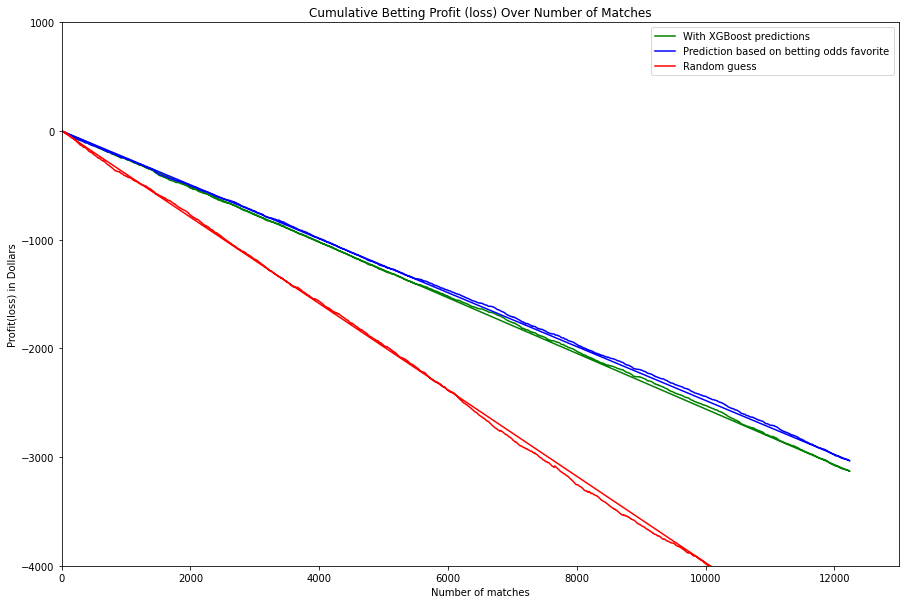

In [143]:
x_data = []
y1_data = []
y2_data = []
y3_data = []

fig, ax = plt.subplots(figsize=(15,10))
plt.title('Cumulative Betting Profit (loss) Over Number of Matches')
plt.xlabel('Number of matches')
plt.ylabel('Profit(loss) in Dollars')
ax.set_xlim(0,13000)
ax.set_ylim(-4000,1000)
line, = ax.plot(0,0, color='green', label='With XGBoost predictions')
line2, = ax.plot(0,0, color='blue', label='Prediction based on betting odds favorite')
line3, = ax.plot(0,0, color='red', label='Random guess')
plt.legend()

def animation_frame(i):
    x_data.append(x_axis[i])
    y1_data.append(y_best_model_profit[i])
    y2_data.append(y_favorite_profit[i])
    y3_data.append(y_dummy_profit[i])

    line.set_xdata(x_data)
    line.set_ydata(y1_data)
    line2.set_xdata(x_data)
    line2.set_ydata(y2_data)
    line3.set_xdata(x_data)
    line3.set_ydata(y3_data)
    return line,

animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(0,len(x_axis),6), interval=0.001)
animation.save(OUTPUT_DATA_PATH + 'animation.gif', writer='pillow', fps=30)

In [139]:
print(classification_report(y_test, y_pred))
print(pd.crosstab(y_test, y_pred))
betting_loss(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.89      0.70      0.79      9888
           1       0.34      0.65      0.45      2354

    accuracy                           0.69     12242
   macro avg       0.62      0.68      0.62     12242
weighted avg       0.79      0.69      0.72     12242

col_0       0     1
Has_Won            
0        6923  2965
1         822  1532
Total number of matches: 12242
Total Loss incurred: 3131.7144000000008


3131.7144000000008

In [140]:
print(classification_report(y_test, y_favorite_pred))
print(pd.crosstab(y_test, y_favorite_pred))
betting_loss(y_test, y_favorite_pred)

              precision    recall  f1-score   support

           0       0.89      0.72      0.79      9888
           1       0.35      0.64      0.45      2354

    accuracy                           0.70     12242
   macro avg       0.62      0.68      0.62     12242
weighted avg       0.79      0.70      0.73     12242

col_0     0.0   1.0
Has_Won            
0        7079  2809
1         849  1505
Total number of matches: 12242
Total Loss incurred: 3035.7332166666674


3035.7332166666674

In [141]:
print(classification_report(y_test, y_dummy_pred))
print(pd.crosstab(y_test, y_dummy_pred))
betting_loss(y_test, y_dummy_pred)

              precision    recall  f1-score   support

           0       0.81      0.51      0.62      9888
           1       0.20      0.51      0.29      2354

    accuracy                           0.51     12242
   macro avg       0.51      0.51      0.45     12242
weighted avg       0.70      0.51      0.56     12242

col_0       0     1
Has_Won            
0        5003  4885
1        1147  1207
Total number of matches: 12242
Total Loss incurred: 4860.80325


4860.80325